## Advanced Soft Computing Final Project (Deep Learning) ##

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy
from pandas import read_csv
import math
from keras.layers import LSTM, GRU
from sklearn.metrics import mean_squared_error

# Data

In [2]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


### Importing the Data

In [95]:
# To view the results of a particular company, uncomment the company name path and execute
  # the Jupyter file

#file_path = '/drive/My Drive/Colab Notebooks/soft_computing/data/IEP.csv'
#file_path = '/drive/My Drive/Colab Notebooks/soft_computing/data/AMGN.csv'
#file_path = '/drive/My Drive/Colab Notebooks/soft_computing/data/AMZN.csv'
#file_path = '/drive/My Drive/Colab Notebooks/soft_computing/data/BA.csv'
#file_path = '/drive/My Drive/Colab Notebooks/soft_computing/data/BABA.csv'
#file_path = '/drive/My Drive/Colab Notebooks/soft_computing/data/BRK-A.csv'
#file_path = '/drive/My Drive/Colab Notebooks/soft_computing/data/CHTR.csv'
#file_path = '/drive/My Drive/Colab Notebooks/soft_computing/data/GOOG.csv'
#file_path = '/drive/My Drive/Colab Notebooks/soft_computing/data/LMT.csv'
file_path = '/drive/My Drive/Colab Notebooks/soft_computing/data/PCLN.csv'

df_ge = pd.read_csv(file_path, engine='python').drop(columns=['Adj Close'])
df_ge['Date'] =pd.to_datetime(df_ge['Date'])
df_ge.set_index('Date', drop=True, inplace=True)
target_col = 'Close'
x = df_ge[df_ge.columns.drop(['Low', 'Volume'])].values 
y = df_ge[target_col].values
df_ge.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-09-04,604.250000,606.489990,595.000000,596.890015,736200
2012-09-05,597.500000,601.719971,594.450012,595.179993,480800
2012-09-06,599.570007,609.239990,597.260010,604.000000,1055600
2012-09-07,612.500000,622.890015,612.109985,621.549988,1627000
2012-09-10,620.969971,624.500000,607.460022,608.320007,907700


In [96]:
df_ordered = df_ge[['Open', 'High', 'Low', 'Volume', 'Close']]
df_ordered

,Open,High,Low,Volume,Close
Date,,,,,
2012-09-04,604.250000,606.489990,595.000000,736200,596.890015
2012-09-05,597.500000,601.719971,594.450012,480800,595.179993
2012-09-06,599.570007,609.239990,597.260010,1055600,604.000000
2012-09-07,612.500000,622.890015,612.109985,1627000,621.549988
2012-09-10,620.969971,624.500000,607.460022,907700,608.320007
...,...,...,...,...,...
2017-08-28,1800.000000,1805.000000,1782.449951,485800,1789.910034
2017-08-29,1775.900024,1811.000000,1774.400024,488800,1807.060059
2017-08-30,1809.099976,1818.800049,1808.150024,333400,1813.000000


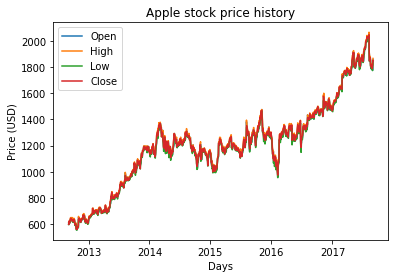

In [97]:
plt.figure()
plt.plot(df_ordered["Open"])
plt.plot(df_ordered["High"])
plt.plot(df_ordered["Low"])
plt.plot(df_ordered["Close"])
plt.title('Apple stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

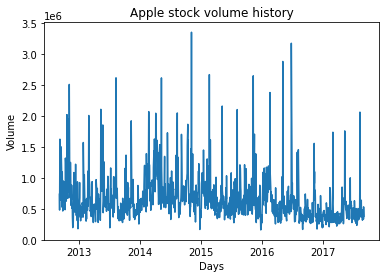

In [98]:
plt.figure()
plt.plot(df_ordered["Volume"])
plt.title('Apple stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [99]:
# Function to convert an array of values into a dataset matrix

def create_dataset(dataset, target_col_index, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, target_col_index])

	return numpy.array(dataX), numpy.array(dataY)
 

def dataset_scaling(df_ordered, target_col_index):
  dataset = df_ordered.values
  dataset = dataset.astype('float32')

  # Scaling dataset
  
  scaler_X = MinMaxScaler(feature_range=(0, 1))
  scaler_Y = MinMaxScaler(feature_range=(0, 1))

  dataset_X =  np.delete(dataset, target_col_index, 1)
  dataset_Y = dataset[:,target_col_index].reshape(-1, 1)

  dataset_X = scaler_X.fit_transform(dataset_X)
  dataset_Y = scaler_Y.fit_transform(dataset_Y)

  dataset = np.concatenate((dataset_X, dataset_Y), axis=1)

  return dataset, scaler_X, scaler_Y

def train_predict(dataset, target_col_index, look_back, network_type):

  # Splitting the Dataset
  train_size = int(len(dataset) * 0.67)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
  # Reshaping X=t and Y=t+1
  trainX, trainY = create_dataset(train, target_col_index, look_back)

  testX, testY = create_dataset(test, target_col_index, look_back)

  # Fitting the LSTM network
  n_neurons = 4
  model = Sequential()

  if network_type == 'GRU':
    model.add(GRU(n_neurons, input_shape=(trainX.shape[1], trainX.shape[2])))
  if network_type == 'LSTM':
    model.add(LSTM(n_neurons, input_shape=(trainX.shape[1], trainX.shape[2])))

  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
  
  # Predicting the values
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  # Inverting the Predictions
  trainPredict = scaler_Y.inverse_transform(trainPredict)
  trainY = scaler_Y.inverse_transform(trainY.reshape(-1, 1))
  testPredict = scaler_Y.inverse_transform(testPredict)
  testY = scaler_Y.inverse_transform(testY.reshape(-1, 1))

  return trainY, trainPredict, testY, testPredict


In [100]:
target_col_index = 4
look_back = 1
dataset, scaler_X, scaler_Y = dataset_scaling(df_ordered, target_col_index)

In [101]:
# LSTM
network_type = 'LSTM'
trainY_lstm, trainPredict_lstm, testY_lstm, testPredict_lstm = train_predict(dataset, target_col_index,look_back, network_type)

# Root Mean Squared Error (RMSE)
trainScore = math.sqrt(mean_squared_error(trainY_lstm, trainPredict_lstm[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_lstm, testPredict_lstm[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Epoch 1/10
840/840 - 3s - loss: 0.0105
Epoch 2/10
840/840 - 1s - loss: 2.8282e-04
Epoch 3/10
840/840 - 1s - loss: 2.1396e-04
Epoch 4/10
840/840 - 1s - loss: 2.1561e-04
Epoch 5/10
840/840 - 1s - loss: 2.1361e-04
Epoch 6/10
840/840 - 1s - loss: 2.0548e-04
Epoch 7/10
840/840 - 1s - loss: 2.0545e-04
Epoch 8/10
840/840 - 1s - loss: 2.1296e-04
Epoch 9/10
840/840 - 1s - loss: 2.0793e-04
Epoch 10/10
840/840 - 1s - loss: 2.0895e-04
Train Score: 20.56 RMSE
Test Score: 86.97 RMSE


In [102]:
# GRU
network_type = 'GRU'
trainY_gru, trainPredict_gru, testY_gru, testPredict_gru = train_predict(dataset, target_col_index, look_back, network_type)

# Root Mean Squared Error (RMSE)
trainScore = math.sqrt(mean_squared_error(trainY_gru, trainPredict_gru[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_gru, testPredict_gru[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/10
840/840 - 3s - loss: 0.0034
Epoch 2/10
840/840 - 1s - loss: 2.4044e-04
Epoch 3/10
840/840 - 1s - loss: 2.5123e-04
Epoch 4/10
840/840 - 1s - loss: 2.4133e-04
Epoch 5/10
840/840 - 1s - loss: 2.3493e-04
Epoch 6/10
840/840 - 1s - loss: 2.3711e-04
Epoch 7/10
840/840 - 1s - loss: 2.4406e-04
Epoch 8/10
840/840 - 1s - loss: 2.3689e-04
Epoch 9/10
840/840 - 1s - loss: 2.2489e-04
Epoch 10/10
840/840 - 1s - loss: 2.2843e-04
Train Score: 20.86 RMSE
Test Score: 44.04 RMSE


In [103]:
# Ensemble Learning
trainY = (trainY_gru+ trainPredict_lstm)/2
trainPredict = (trainPredict_gru+trainPredict_lstm)/2
testY = (testY_gru+testY_lstm)/2
testPredict = (testPredict_gru+testPredict_lstm)/2

# Root Mean Squared Error (RMSE)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.43 RMSE
Test Score: 64.70 RMSE


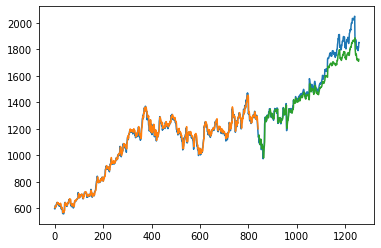

In [104]:
# Shifting the train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shifting the test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plotting baseline and predictions
plt.plot(scaler_Y.inverse_transform(dataset[:,target_col_index].reshape(-1,1)))
plt.plot(trainPredictPlot[:,target_col_index])
plt.plot(testPredictPlot[:,target_col_index])
plt.show()


################################################################################